<a href="https://colab.research.google.com/github/nbegumc/market-basket-analysis/blob/master/Final_Project_MBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Algorithms for Massive Data** / 2020-21 <br>
  ## Master in Data Science and Economics <br>
     Nazli Begum Cirpanli - 942345

> # **Market-basket Analysis**
 



**Installing Spark and importing necessary libraries**

In [1]:
!pip install pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

     |████████████████████████████████| 212.4 MB 64 kB/s 
     |████████████████████████████████| 198 kB 50.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=38ea6e86b247658efbe08a52f1dd3d3ece055ab8f9aa76d184a118b5de00b8c7
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


In [2]:
MAX_MEMORY = "5g"
spark = SparkSession.builder.config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory", MAX_MEMORY).enableHiveSupport().getOrCreate()

In [3]:
import pyspark
sc=spark.sparkContext

In [4]:
from pyspark.sql import functions as f
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

**IMPORTING DATA**

Importing the «IMDB» dataset available on Kaggle.

In [5]:
!pip install kaggle

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazlbe","key":"91a835680d578840698c3fa308f3eaee"}'}

In [7]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [8]:
!kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.44G/1.44G [00:13<00:00, 107MB/s]
100% 1.44G/1.44G [00:13<00:00, 114MB/s]


In [9]:
!unzip imdb-dataset.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


In [10]:
# checking whether all the files have been downloaded to the directory
!ls

imdb-dataset.zip    title.akas.tsv	  title.principals.tsv.gz
kaggle.json	    title.akas.tsv.gz	  title.ratings.tsv
name.basics.tsv     title.basics.tsv	  title.ratings.tsv.gz
name.basics.tsv.gz  title.basics.tsv.gz
sample_data	    title.principals.tsv


In [ ]:
# reading the necessary files and creating temporary tables

# considering movies as baskets and actors as items, frequent itemsets will be found. Hence, files containing information about 
# people and movies will be kept:

# names, basics and principals

In [11]:
names= spark.read.csv("/content/name.basics.tsv/name.basics.tsv",sep='\t', header=True, inferSchema=True)
basics=spark.read.csv("/content/title.basics.tsv/title.basics.tsv",sep='\t',header=True, inferSchema=True)
principals=spark.read.csv("/content/title.principals.tsv/title.principals.tsv",sep='\t',header=True, inferSchema=True)



In [12]:
names.createOrReplaceTempView("names")
basics.createOrReplaceTempView("basics")
principals.createOrReplaceTempView("principals")


**EXPLORATORY ANALYSIS**

Exploring the data contained in the files and basic visualisations.

In [13]:
names.show(n=5, truncate=False)

+---------+---------------+---------+---------+------------------------------+---------------------------------------+
|nconst   |primaryName    |birthYear|deathYear|primaryProfession             |knownForTitles                         |
+---------+---------------+---------+---------+------------------------------+---------------------------------------+
|nm0000001|Fred Astaire   |1899     |1987     |soundtrack,actor,miscellaneous|tt0050419,tt0053137,tt0072308,tt0043044|
|nm0000002|Lauren Bacall  |1924     |2014     |actress,soundtrack            |tt0071877,tt0117057,tt0038355,tt0037382|
|nm0000003|Brigitte Bardot|1934     |\N       |actress,soundtrack,producer   |tt0054452,tt0049189,tt0059956,tt0057345|
|nm0000004|John Belushi   |1949     |1982     |actor,writer,soundtrack       |tt0077975,tt0072562,tt0080455,tt0078723|
|nm0000005|Ingmar Bergman |1918     |2007     |writer,director,actor         |tt0069467,tt0050976,tt0083922,tt0050986|
+---------+---------------+---------+---------+-

In [14]:
# from the names file, people whose primary profession is either actor or actress are filtered
actors=names.filter((f.array_contains(f.array(names.primaryProfession),"actor"))|(f.array_contains(f.array(names.primaryProfession),"actress")))

In [ ]:
actors.show(n=10,truncate=False)

+---------+-----------------+---------+---------+-----------------+---------------------------------------+
|nconst   |primaryName      |birthYear|deathYear|primaryProfession|knownForTitles                         |
+---------+-----------------+---------+---------+-----------------+---------------------------------------+
|nm0000084|Li Gong          |1965     |\N       |actress          |tt0473444,tt0101640,tt0397535,tt0430357|
|nm0000109|Yasmine Bleeth   |1968     |\N       |actress          |tt0131857,tt0115285,tt0337851,tt0119271|
|nm0000124|Jennifer Connelly|1970     |\N       |actress          |tt0315983,tt0180093,tt0268978,tt0102803|
|nm0000143|Erika Eleniak    |1969     |\N       |actress          |tt0083866,tt0094761,tt0106400,tt0105690|
|nm0000157|Linda Hamilton   |1956     |\N       |actress          |tt0103064,tt6450804,tt0088247,tt0118928|
|nm0000266|Ursula Andress   |1936     |\N       |actress          |tt0061452,tt0055928,tt0082186,tt0060177|
|nm0000282|Scott Bairstow   

In [ ]:
# have a look at the names
actors.select('primaryName').distinct().show()

+---------------+
|    primaryName|
+---------------+
|     Lex Barker|
| Lisa Cangelosi|
|      Bob Aaron|
|   Claire Abbey|
|  Dorothy Adams|
|    Yashaw Adem|
|Michaela Adkins|
|    Bryen Adler|
| Barbara Adolph|
|  Débora Adorno|
| Philippe Aerts|
| Hamilton Agben|
| Anders Ahlberg|
| Sadie Ahnedova|
|    Ann Ainslee|
|    Noe Akimoto|
|     Joe Akonor|
|  Hasan Akyurek|
|     Jess Alvan|
|   Rosa Alberti|
+---------------+
only showing top 20 rows



In [ ]:
# The number of all actors and actresses
actors.select('nconst').distinct().count()

2914287

In [ ]:
# from the Basics table, rows which have the titleType=movie are filtered

In [15]:
basics.show(n=5, truncate=False)

+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tconst   |titleType|primaryTitle          |originalTitle         |isAdult|startYear|endYear|runtimeMinutes|genres                  |
+---------+---------+----------------------+----------------------+-------+---------+-------+--------------+------------------------+
|tt0000001|short    |Carmencita            |Carmencita            |0      |1894     |\N     |1             |Documentary,Short       |
|tt0000002|short    |Le clown et ses chiens|Le clown et ses chiens|0      |1892     |\N     |5             |Animation,Short         |
|tt0000003|short    |Pauvre Pierrot        |Pauvre Pierrot        |0      |1892     |\N     |4             |Animation,Comedy,Romance|
|tt0000004|short    |Un bon bock           |Un bon bock           |0      |1892     |\N     |\N            |Animation,Short         |
|tt0000005|short    |Blacksmith Scene      |Blacksmith Scene  

In [ ]:
basics.select('titleType').distinct().show()

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|     tvMovie|
|   tvEpisode|
|       movie|
|   tvSpecial|
|       video|
|   videoGame|
|     tvShort|
|       short|
+------------+



In [16]:
basics_movies=basics.filter(basics.titleType=='movie')
basics_movies.show(n=10,truncate=False)

+---------+---------+-------------------------------+-------------------------------+-------+---------+-------+--------------+----------------------+
|tconst   |titleType|primaryTitle                   |originalTitle                  |isAdult|startYear|endYear|runtimeMinutes|genres                |
+---------+---------+-------------------------------+-------------------------------+-------+---------+-------+--------------+----------------------+
|tt0000009|movie    |Miss Jerry                     |Miss Jerry                     |0      |1894     |\N     |45            |Romance               |
|tt0000147|movie    |The Corbett-Fitzsimmons Fight  |The Corbett-Fitzsimmons Fight  |0      |1897     |\N     |20            |Documentary,News,Sport|
|tt0000335|movie    |Soldiers of the Cross          |Soldiers of the Cross          |0      |1900     |\N     |\N            |Biography,Drama       |
|tt0000502|movie    |Bohemios                       |Bohemios                       |0      |1905   

In [17]:
principals.show(n=5,truncate=False)

+---------+--------+---------+---------------+-----------------------+-----------+
|tconst   |ordering|nconst   |category       |job                    |characters |
+---------+--------+---------+---------------+-----------------------+-----------+
|tt0000001|1       |nm1588970|self           |\N                     |["Herself"]|
|tt0000001|2       |nm0005690|director       |\N                     |\N         |
|tt0000001|3       |nm0374658|cinematographer|director of photography|\N         |
|tt0000002|1       |nm0721526|director       |\N                     |\N         |
|tt0000002|2       |nm1335271|composer       |\N                     |\N         |
+---------+--------+---------+---------------+-----------------------+-----------+
only showing top 5 rows



In [ ]:
# all the people in the names table:

In [18]:
people= (
    names
    .withColumn("titles_array", f.split("primaryProfession", "\,"))
    .withColumn("primaryProfession", f.explode("titles_array"))
    .select("nconst", "primaryName","primaryProfession")
)

In [ ]:
people.createOrReplaceTempView('people')
people.show()

+---------+---------------+-----------------+
|   nconst|    primaryName|primaryProfession|
+---------+---------------+-----------------+
|nm0000001|   Fred Astaire|       soundtrack|
|nm0000001|   Fred Astaire|            actor|
|nm0000001|   Fred Astaire|    miscellaneous|
|nm0000002|  Lauren Bacall|          actress|
|nm0000002|  Lauren Bacall|       soundtrack|
|nm0000003|Brigitte Bardot|          actress|
|nm0000003|Brigitte Bardot|       soundtrack|
|nm0000003|Brigitte Bardot|         producer|
|nm0000004|   John Belushi|            actor|
|nm0000004|   John Belushi|           writer|
|nm0000004|   John Belushi|       soundtrack|
|nm0000005| Ingmar Bergman|           writer|
|nm0000005| Ingmar Bergman|         director|
|nm0000005| Ingmar Bergman|            actor|
|nm0000006| Ingrid Bergman|          actress|
|nm0000006| Ingrid Bergman|       soundtrack|
|nm0000006| Ingrid Bergman|         producer|
|nm0000007|Humphrey Bogart|            actor|
|nm0000007|Humphrey Bogart|       

In [ ]:
# number of people belonging to each category in the "people" table

In [ ]:
query = """SELECT  primaryProfession AS profession, COUNT(*) AS people
           FROM people
           GROUP BY primaryProfession
           ORDER BY people DESC 
           """
people = spark.sql(query)
people.show()

+--------------------+-------+
|          profession| people|
+--------------------+-------+
|               actor|2266304|
|             actress|1358806|
|       miscellaneous|1011711|
|            producer| 848060|
|              writer| 643224|
|   camera_department| 587557|
|            director| 521860|
|      art_department| 341861|
|    sound_department| 296520|
|     cinematographer| 272597|
|              editor| 255923|
|            composer| 233686|
|  assistant_director| 192597|
|    music_department| 181174|
|      visual_effects| 168755|
|  make_up_department| 168262|
|  production_manager| 158502|
|animation_department| 150381|
|editorial_department| 139044|
|          soundtrack| 132781|
+--------------------+-------+
only showing top 20 rows



In [ ]:
people=people.toPandas()
people = people.set_index("profession")
people

,people
profession,
actor,2266304
actress,1358806
miscellaneous,1011711
producer,848060
writer,643224
camera_department,587557
director,521860
art_department,341861
sound_department,296520


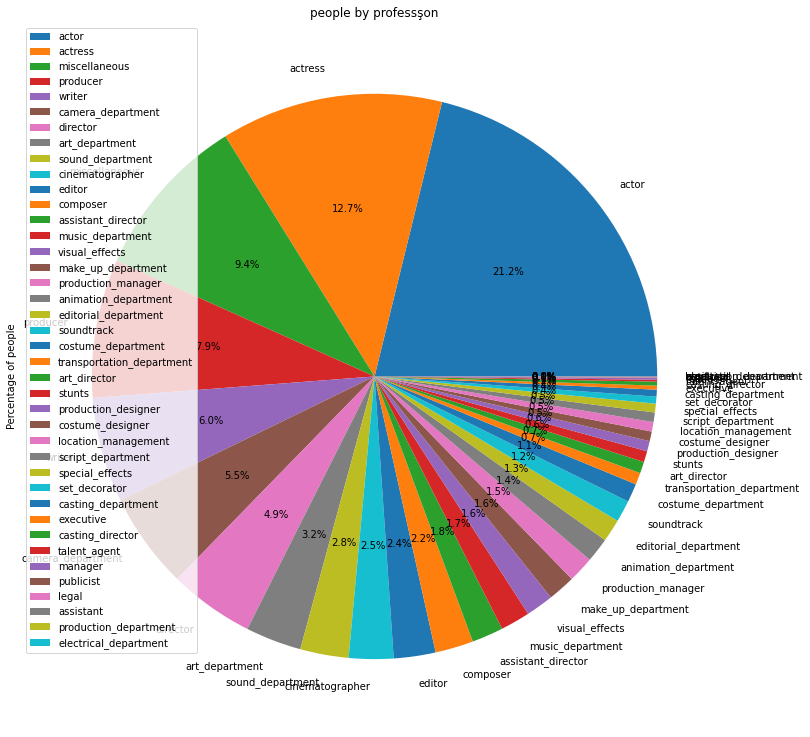

In [ ]:
pie = people.plot.pie(y = "people", figsize = (13,13), autopct = "%1.1f%%")
pie.legend(loc = "upper left");
pie.set(title = "people by professşon", ylabel = "Percentage of people");

In [ ]:
# creating a table which consists both movies and actors/actresses in it:

In [19]:
movies=basics_movies.join(principals,basics_movies.tconst==principals.tconst).select(principals.tconst,basics_movies.primaryTitle,principals.nconst)

In [ ]:
movies.show(n=10,truncate=False)

+---------+-------------------------+---------+--------------+
|tconst   |primaryTitle             |nconst   |primaryName   |
+---------+-------------------------+---------+--------------+
|tt0083109|The Cabbage Soup         |nm0000086|Louis de Funès|
|tt0062120|The Little Bather        |nm0000086|Louis de Funès|
|tt0057422|Squeak-squeak            |nm0000086|Louis de Funès|
|tt0058089|Fantomas                 |nm0000086|Louis de Funès|
|tt1253586|Louis de Funès intime    |nm0000086|Louis de Funès|
|tt0067274|Jo                       |nm0000086|Louis de Funès|
|tt0079200|The Troops & Aliens      |nm0000086|Louis de Funès|
|tt0048994|Babies Galore            |nm0000086|Louis de Funès|
|tt8768374|Le gendarme et l'empereur|nm0000086|Louis de Funès|
|tt0066423|Perched on a Tree        |nm0000086|Louis de Funès|
+---------+-------------------------+---------+--------------+
only showing top 10 rows



In [ ]:
# collecting all the necessary information in one table: movie id, movie title, actor/actress id, actor/actress name

In [20]:
movies=movies.join(names,movies.nconst==names.nconst,"left").select(movies.tconst,movies.primaryTitle,movies.nconst,names.primaryName)

In [21]:
movies.cache()

DataFrame[tconst: string, primaryTitle: string, nconst: string, primaryName: string]

In [22]:
movies.createOrReplaceTempView('movies')

In [ ]:
movies.show(n=10,truncate=False)

+---------+-------------------------+---------+--------------+
|tconst   |primaryTitle             |nconst   |primaryName   |
+---------+-------------------------+---------+--------------+
|tt0083109|The Cabbage Soup         |nm0000086|Louis de Funès|
|tt0062120|The Little Bather        |nm0000086|Louis de Funès|
|tt0057422|Squeak-squeak            |nm0000086|Louis de Funès|
|tt0058089|Fantomas                 |nm0000086|Louis de Funès|
|tt1253586|Louis de Funès intime    |nm0000086|Louis de Funès|
|tt0067274|Jo                       |nm0000086|Louis de Funès|
|tt0079200|The Troops & Aliens      |nm0000086|Louis de Funès|
|tt0048994|Babies Galore            |nm0000086|Louis de Funès|
|tt8768374|Le gendarme et l'empereur|nm0000086|Louis de Funès|
|tt0066423|Perched on a Tree        |nm0000086|Louis de Funès|
+---------+-------------------------+---------+--------------+
only showing top 10 rows



In [ ]:
# visualising top 10 actors/actresses according to their movie appearances

In [ ]:
import seaborn as sns
from wordcloud import WordCloud

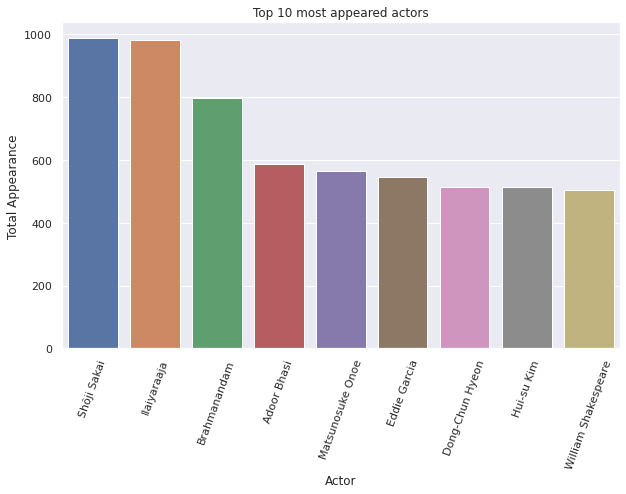

In [ ]:
query = """SELECT primaryName, COUNT(*) AS actor_count
           FROM movies
           GROUP BY primaryName
           ORDER BY actor_count desc
           LIMIT 10"""
appearance = spark.sql(query)
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.barplot(x = "primaryName", y = "actor_count", data = appearance.toPandas())
ax.set(title = "Top 10 most appeared actors", xlabel = "Actor", ylabel = "Total Appearance")
ax.set_xticklabels(ax.get_xticklabels(), rotation=70);

In [ ]:
# checking if the "movies" table contains any null values

In [ ]:
Dict_ = {col:movies.filter(movies[col].isNull()).count() for col in movies.columns}
Dict_

{'nconst': 0, 'primaryName': 1484, 'primaryTitle': 0, 'tconst': 0}

In [ ]:
Dict_ = {col:movies.filter(movies[col]=='\\N').count() for col in movies.columns}
Dict_

{'nconst': 0, 'primaryName': 0, 'primaryTitle': 0, 'tconst': 0}

In [ ]:
Dict_ = {col:movies.filter(movies[col]==' ').count() for col in movies.columns}
Dict_

{'nconst': 0, 'primaryName': 0, 'primaryTitle': 0, 'tconst': 0}

In [ ]:
# only null values are in 'primaryName' attribute. Since 'tconst' (actor id) will be enough for this analysis, 
# primaryName null values do not pose any threat and will be left untouched.

In [ ]:
print((movies.count(), len(movies.columns)))

(3800079, 4)


In [23]:
## Creating baskets
movie_baskets=movies.groupBy('tconst').agg(f.collect_set('nconst').alias('actors'))

In [ ]:
movie_baskets.show()

+---------+--------------------+
|   tconst|              actors|
+---------+--------------------+
|tt0002591|[nm0029806, nm050...|
|tt0003689|[nm0910564, nm052...|
|tt0004272|[nm0092665, nm036...|
|tt0004336|[nm0916379, nm026...|
|tt0005209|[nm0148859, nm059...|
|tt0005605|[nm0364218, nm007...|
|tt0005617|         [nm0444797]|
|tt0005793|[nm0606530, nm049...|
|tt0005912|[nm0613966, nm000...|
|tt0006204|[nm0071601, nm007...|
|tt0006207|[nm0356267, nm023...|
|tt0006441|[nm0546121, nm090...|
|tt0006489|[nm0842521, nm044...|
|tt0006587|[nm0617202, nm013...|
|tt0006819|[nm0652650, nm043...|
|tt0007011|[nm0785823, nm082...|
|tt0007169|         [nm0856842]|
|tt0007565|[nm0820105, nm079...|
|tt0007694|[nm0330373, nm026...|
|tt0008160|[nm0145776, nm054...|
+---------+--------------------+
only showing top 20 rows



In [24]:
movie_baskets.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- actors: array (nullable = false)
 |    |-- element: string (containsNull = false)



In [25]:
movie_baskets.cache()

DataFrame[tconst: string, actors: array<string>]

In [ ]:
# number of baskets
print(movie_baskets.count(), len(movie_baskets.columns))

522758 2


In [ ]:
# displaying basket sizes

In [ ]:
basket_sizes=movie_baskets.withColumn("size", f.size("actors")).select('*')
basket_sizes.sort('size',ascending=False).show()

+---------+--------------------+----+
|   tconst|              actors|size|
+---------+--------------------+----+
|tt0008261|[nm0351960, nm052...|  10|
|tt0014099|[nm0524306, nm059...|  10|
|tt0008321|[nm0795059, nm084...|  10|
|tt0008890|[nm0161366, nm059...|  10|
|tt0009137|[nm0567756, nm010...|  10|
|tt0004302|[nm0279530, nm059...|  10|
|tt0009418|[nm0668927, nm072...|  10|
|tt0005828|[nm0612348, nm008...|  10|
|tt0009423|[nm0319599, nm005...|  10|
|tt0005957|[nm0738082, nm056...|  10|
|tt0006600|[nm0753583, nm028...|  10|
|tt0009784|[nm0322170, nm094...|  10|
|tt0007001|[nm0286788, nm027...|  10|
|tt0010049|[nm0337801, nm020...|  10|
|tt0007753|[nm0562866, nm053...|  10|
|tt0010056|[nm0082537, nm000...|  10|
|tt0003752|[nm0207764, nm086...|  10|
|tt0010915|[nm0258197, nm040...|  10|
|tt0005250|[nm0692105, nm012...|  10|
|tt0011742|[nm1084225, nm047...|  10|
+---------+--------------------+----+
only showing top 20 rows



In [ ]:
# grouping baskets according to their sizes

In [ ]:
basket_sizes.groupBy('size').count().sort('count',ascending=False).show()

+----+------+
|size| count|
+----+------+
|  10|234027|
|   9| 46237|
|   1| 41273|
|   8| 33016|
|   2| 31906|
|   3| 29332|
|   4| 28461|
|   7| 27159|
|   5| 25688|
|   6| 25659|
+----+------+



In [26]:
# in order to decide on the support number, we should first check the average number of movies an actor plays

actor_movie_numbers=movies.groupBy('nconst').agg(f.collect_set('tconst').alias('movie_titles')).withColumn("size", f.size("movie_titles")).select('*').sort('size',ascending=False)

In [ ]:
actor_movie_numbers.groupby('size').count().sort('count',ascending=False).show()

+----+------+
|size| count|
+----+------+
|   1|829386|
|   2|169589|
|   3| 75754|
|   4| 43802|
|   5| 28363|
|   6| 20310|
|   7| 14727|
|   8| 11302|
|   9|  9062|
|  10|  7343|
|  11|  6087|
|  12|  5073|
|  13|  4247|
|  14|  3756|
|  15|  3169|
|  16|  2829|
|  17|  2541|
|  18|  2229|
|  19|  1999|
|  20|  1829|
+----+------+
only showing top 20 rows



In [ ]:
######################################

**A PRIORI**

In [27]:
transaction_df=movie_baskets.select('actors').rdd.flatMap(lambda x: x)
lines = transaction_df.map(lambda line: ','.join(str(d) for d in line))
lines.saveAsTextFile('itemsets.txt')
transactions = sc.textFile('itemsets.txt').map(lambda x: [str(y) for y in x.strip().split(',')])

In [28]:
transactions.cache()

PythonRDD[92] at RDD at PythonRDD.scala:53

In [ ]:
print(transactions.collect()[:3])

[['nm0526275', 'nm0064949', 'nm0414887', 'nm0249426', 'nm0830249', 'nm0526234', 'nm0005748', 'nm0018814', 'nm0251622', 'nm0803705'], ['nm0485880', 'nm0205986', 'nm0163540', 'nm0608971', 'nm0130576', 'nm0502700', 'nm0676473', 'nm0724397', 'nm0050150', 'nm0299052'], ['nm0354282', 'nm0048512', 'nm0824332', 'nm0176699', 'nm0305087', 'nm0518711', 'nm0712870', 'nm0098376']]


In [ ]:
#defining the minimum support value   
count= transactions.count()        
min_support= 0.0004*count     
min_support

209.10320000000002

In [ ]:
# function that creates all the candidate values

In [29]:
def get_candidates(frequents,n):
  frequents=frequents.collect()
  if (n==2):
    singles = set()
    for item in frequents:
      singles.add(item)
    
  if (n>2):
    singles=set() 
    for itemsets in frequents: 
      for item in itemsets: 
        singles.add(item) 
        
  candidates=[set(itemsets) for itemsets in list(itertools.combinations(singles, n))] 
  return candidates

In [ ]:
# function that gives the candidates and the total number of their appearances

In [30]:
def count_candidates(x, candidates):
    c_list = []
    for itemsets in candidates:                     
        if set(list(itemsets)).issubset(set(x)):
            c_list.append([tuple(itemsets), 1])
        else:
            c_list.append([tuple(itemsets), 0])
    return c_list

In [ ]:
# function that filters the candidates whose support values are above the minimum support, namely the frequent items

In [31]:
def get_frequent_itemsets(candidates, itemsets, support):
    frequent_item_set = itemsets.flatMap(lambda x: count_candidates(x, candidates)).reduceByKey(lambda a, b: a+b).map(lambda x: (x[0], x[1])).filter(lambda x: x[1]>=support)
    return frequent_item_set

In [ ]:
# function that checks whether there is still higher order item sets to be generated

In [32]:
def not_empty(freq_sets):
    return (freq_sets.count() > 0) and (freq_sets is not None)

In [ ]:
# A Priori algorithm:

In [33]:
def apriori(itemsets,support):
      
   act_freqRDD=(itemsets.flatMap(lambda x:x).map(lambda i: (i, 1)).reduceByKey(lambda a,b: a+b))
   frequents_RDD= act_freqRDD.map(lambda x: (x[0], x[1])).filter(lambda x: x[1]>=support)
   
   supportRDD = frequents_RDD.map(lambda item: ([item[0]] , item[1])) 
    
   frequents_RDD= frequents_RDD.map(lambda x:x[0])  
   n=2
  
   while not_empty(frequents_RDD):
     
     candidate_sets = get_candidates(frequents_RDD, n)
     frequent_itemsets = get_frequent_itemsets(candidate_sets, itemsets, support)
     supportRDD  = supportRDD.union(frequent_itemsets)
     frequents_RDD = frequent_itemsets.map(lambda x:x[0])
     
   
     n += 1
   
   return supportRDD

In [ ]:
# Frequent Items and the duration of the A Priori algorithm

In [ ]:
from datetime import datetime ## min_support=0.0004
start_time = datetime.now()
print(apriori(transactions, min_support).collect())
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[(['nm0945427'], 218), (['nm1046041'], 237), (['nm0767266'], 285), (['nm0793881'], 224), (['nm0006064'], 383), (['nm0764762'], 247), (['nm0045119'], 251), (['nm0893449'], 240), (['nm1058607'], 283), (['nm0802846'], 212), (['nm1894124'], 273), (['nm0006137'], 981), (['nm0415549'], 302), (['nm0766496'], 227), (['nm1006879'], 240), (['nm0793813'], 411), (['nm0482320'], 346), (['nm0659173'], 214), (['nm0798827'], 237), (['nm0005983'], 279), (['nm0474820'], 230), (['nm0688093'], 262), (['nm0701403'], 394), (['nm0994324'], 320), (['nm0706691'], 316), (['nm0297772'], 223), (['nm0756966'], 988), (['nm0588316'], 275), (['nm0374974'], 286), (['nm0997109'], 354), (['nm0004417'], 290), (['nm0004467'], 212), (['nm0046850'], 348), (['nm1069523'], 224), (['nm0080173'], 230), (['nm0222432'], 274), (['nm0462051'], 381), (['nm0006369'], 280), (['nm0104418'], 223), (['nm0154164'], 236), (['nm0627864'], 213), (['nm0695177'], 221), (['nm1066548'], 229), (['nm0455836'], 210), (['nm0623427'], 439), (['nm0538

In [ ]:
from datetime import datetime #0.0005
start_time = datetime.now()
print(apriori(transactions, min_support).collect())
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[(['nm0767266'], 285), (['nm0006064'], 383), (['nm1058607'], 283), (['nm1894124'], 273), (['nm0006137'], 981), (['nm0415549'], 302), (['nm0793813'], 411), (['nm0482320'], 346), (['nm0005983'], 279), (['nm0688093'], 262), (['nm0701403'], 394), (['nm0706691'], 316), (['nm0994324'], 320), (['nm0588316'], 275), (['nm0756966'], 988), (['nm0374974'], 286), (['nm0997109'], 354), (['nm0046850'], 348), (['nm0004417'], 290), (['nm0222432'], 274), (['nm0462051'], 381), (['nm0006369'], 280), (['nm0623427'], 439), (['nm0232490'], 515), (['nm0619107'], 399), (['nm1047085'], 283), (['nm0001000'], 313), (['nm0619309'], 313), (['nm0035067'], 300), (['nm0001553'], 306), (['nm0000465'], 389), (['nm0453459'], 512), (['nm0222219'], 298), (['nm0644554'], 440), (['nm0649320'], 331), (['nm3183374'], 262), (['nm0006982'], 586), (['nm0648803'], 565), (['nm0304262'], 323), (['nm0005996'], 320), (['nm0191097'], 280), (['nm0004429'], 278), (['nm0006136'], 266), (['nm0960106'], 333), (['nm0023173'], 265), (['nm0473

**FP GROWTH**

In [34]:
#Displaying of frequent itemsets, association rules and predictions with FP-growth package

from pyspark.ml.fpm import FPGrowth

In [35]:
movie_baskets.toPandas().head(5)


,tconst,actors
0,tt0002591,"[nm0029806, nm0509573, nm0296193]"
1,tt0003689,"[nm0910564, nm0527801, nm0399988, nm0101071, n..."
2,tt0004272,"[nm0092665, nm0368875, nm0492302, nm0445507, n..."
3,tt0004336,"[nm0916379, nm0268437, nm0811293, nm0102718, n..."
4,tt0005209,"[nm0148859, nm0593671, nm0331456, nm0226992, n..."


In [ ]:
# Frequent Items and the duration of the FPGrowth algorithm with minSupport=0.0004, minConfidence=0
import time
start_time = time.time()
fpGrowth = FPGrowth(itemsCol="actors", minSupport=0.0004, minConfidence=0)
model = fpGrowth.fit(movie_baskets)
model.freqItemsets.show(truncate=False)
end_time = time.time()
print('Duration: {}'.format(end_time - start_time))

+----------------------+----+
|items                 |freq|
+----------------------+----+
|[nm0756966]           |988 |
|[nm0006137]           |981 |
|[nm0103977]           |798 |
|[nm0006982]           |586 |
|[nm0648803]           |565 |
|[nm0305182]           |541 |
|[nm0232490]           |515 |
|[nm0453459]           |512 |
|[nm0000636]           |497 |
|[nm0473742]           |465 |
|[nm0644554]           |440 |
|[nm0623427]           |439 |
|[nm0623427, nm0006982]|237 |
|[nm0481568]           |439 |
|[nm1930572]           |433 |
|[nm0793813]           |411 |
|[nm0156963]           |404 |
|[nm0619107]           |399 |
|[nm0701403]           |394 |
|[nm0701403, nm0473742]|394 |
+----------------------+----+
only showing top 20 rows

Duration: 37.7841579914093


In [ ]:
# Display frequent itemsets.
mostPopularActorInABasket = model.freqItemsets
mostPopularActorInABasket.createOrReplaceTempView("mostPopularActorInABasket")
mostPopularActorInABasket.sort('freq', ascending=False).show(truncate=False)

# Display generated association rules.
associationRules = model.associationRules
associationRules.createOrReplaceTempView("associationRules")
associationRules.sort('confidence', ascending=False).show(truncate=False)

# transform examines the input items against all the association rules and summarize the consequents as prediction
associations = model.transform(movie_baskets)
associations.sort('prediction', ascending=False).show(truncate=False)


+----------------------+----+
|items                 |freq|
+----------------------+----+
|[nm0756966]           |988 |
|[nm0006137]           |981 |
|[nm0103977]           |798 |
|[nm0006982]           |586 |
|[nm0648803]           |565 |
|[nm0305182]           |541 |
|[nm0232490]           |515 |
|[nm0453459]           |512 |
|[nm0000636]           |497 |
|[nm0473742]           |465 |
|[nm0644554]           |440 |
|[nm0623427]           |439 |
|[nm0481568]           |439 |
|[nm1930572]           |433 |
|[nm0793813]           |411 |
|[nm0156963]           |404 |
|[nm0619107]           |399 |
|[nm0701403]           |394 |
|[nm0701403, nm0473742]|394 |
|[nm0246703]           |391 |
+----------------------+----+
only showing top 20 rows

+-----------+-----------+------------------+------------------+--------------------+
|antecedent |consequent |confidence        |lift              |support             |
+-----------+-----------+------------------+------------------+--------------------+

In [ ]:
#Most frequent basket of items (containing at least 2 items)

query = """select items, freq
           from mostPopularActorInABasket
           where size(items) > 1
           order by freq desc
           limit 20"""
spark.sql(query).show(truncate=False)

+----------------------+----+
|items                 |freq|
+----------------------+----+
|[nm0701403, nm0473742]|394 |
|[nm0623427, nm0006982]|237 |
+----------------------+----+



In [ ]:
#Association rules
query = """select antecedent as `antecedent (if)`, consequent as `consequent (then)`, confidence
           from associationRules
           order by confidence desc
           limit 20"""

spark.sql(query).show(truncate=False)

+---------------+-----------------+------------------+
|antecedent (if)|consequent (then)|confidence        |
+---------------+-----------------+------------------+
|[nm0701403]    |[nm0473742]      |1.0               |
|[nm0473742]    |[nm0701403]      |0.8473118279569892|
|[nm0623427]    |[nm0006982]      |0.5398633257403189|
|[nm0006982]    |[nm0623427]      |0.4044368600682594|
+---------------+-----------------+------------------+



**APRIORI vs FP GROWTH**

In [ ]:
min_s=[522.758,470.4822,418.20640000000003,365.93059999999997,313.65479999999997]
min_s=[0.001,0.0009,0.0008,0.0007,0.0006]
dur=[659.1206583976746,323.02508568763733,160.63499426841736,107.05950427055359,97.63521099090576]
min_s=[522.758,470.4822,418.20640000000003,365.93059999999997,313.65479999999997]


######**Running algorithms with different supports**

In [36]:
#calculating different supports: 
min_s=[]
for s in [0.0006,0.0007,0.0008,0.0009,0.001]:
  count= transactions.count()        
  min_support= s*count     
  min_s.append(min_support)
min_s

[313.65479999999997, 365.93059999999997, 418.20640000000003, 470.4822, 522.758]

In [ ]:
# running apriori with supports in min_s: 

In [41]:
count= transactions.count()        
min_support= 0.0006*count     

import time 
start_time = time.time()
print(apriori(transactions, min_support).collect())
end_time = time.time()
dur=(end_time - start_time)
dur

[(['nm0006064'], 383), (['nm0006137'], 981), (['nm0793813'], 411), (['nm0482320'], 346), (['nm0701403'], 394), (['nm0706691'], 316), (['nm0994324'], 320), (['nm0756966'], 988), (['nm0997109'], 354), (['nm0046850'], 348), (['nm0462051'], 381), (['nm0623427'], 439), (['nm0232490'], 515), (['nm0619107'], 399), (['nm0000465'], 389), (['nm0453459'], 512), (['nm0644554'], 440), (['nm0649320'], 331), (['nm0006982'], 586), (['nm0648803'], 565), (['nm0304262'], 323), (['nm0005996'], 320), (['nm0960106'], 333), (['nm0473742'], 465), (['nm0246703'], 391), (['nm0156963'], 404), (['nm0627060'], 319), (['nm0103977'], 798), (['nm0305182'], 541), (['nm0007123'], 383), (['nm7390393'], 355), (['nm0149822'], 331), (['nm0481568'], 439), (['nm1350644'], 319), (['nm1930572'], 433), (['nm0000636'], 497), (('nm0473742', 'nm0701403'), 394)]


649.7880444526672

In [42]:
#collecting execution time for different supports in a list

dur=[649.7880444526672,309.48820424079895,154.0873875617981,99.6773374080658,92.28078770637512]

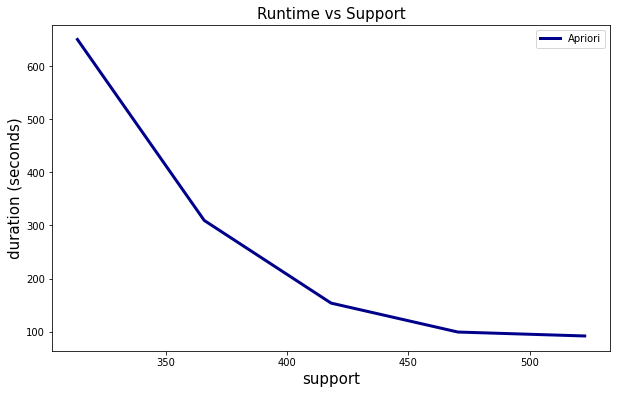

In [44]:
fig, ax = plt.subplots(linewidth = 2, figsize = (10,6))

ax.plot(min_s,dur,linewidth = 3, color = 'darkblue',label="Apriori")
plt.ylabel('duration (seconds)',fontsize=15)
plt.xlabel('support',fontsize=15)

ax.legend(loc=1,fontsize=10)
plt.title('Runtime vs Support',fontsize=15)


plt.show()


In [48]:
#running FP Growth with different supports

dura_fp=[]
for s in [0.0006,0.0007,0.0008,0.0009,0.001]:
  start_time = time.time()
  fpGrowth = FPGrowth(itemsCol="actors", minSupport=s, minConfidence=0)
  model = fpGrowth.fit(movie_baskets)
  end_time = time.time()
  dura_fp.append((end_time - start_time))
dura_fp

[19.71483325958252,
 20.225846767425537,
 19.956292152404785,
 19.906930685043335,
 20.25010895729065]

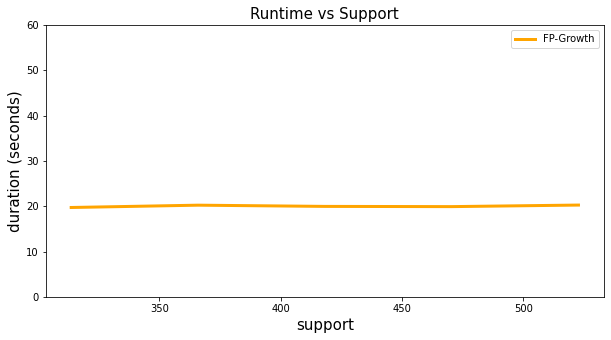

In [49]:
fig, ax = plt.subplots(linewidth = 2, figsize = (10,5))

ax.plot(min_s,dura_fp,linewidth = 3, color = 'orange',label="FP-Growth")
plt.ylabel('duration (seconds)',fontsize=15)
plt.xlabel('support',fontsize=15)
ax.set_ylim([0, 60])
ax.legend(loc=1,fontsize=10)
plt.title('Runtime vs Support',fontsize=15)


plt.show()

Text(0, 0.5, 'duration (seconds)')

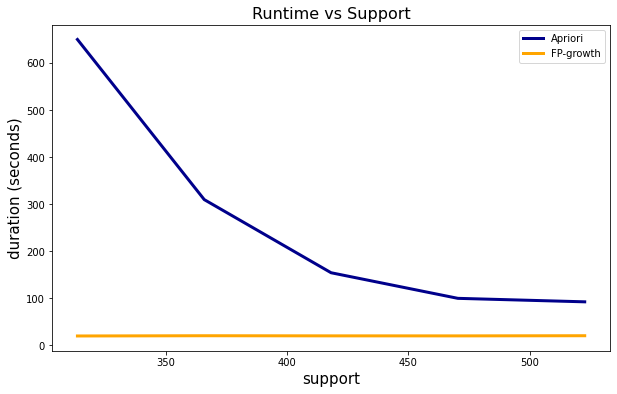

In [50]:
fig, ax = plt.subplots(linewidth = 2, figsize = (10,6),
                      )

ax.plot(min_s,dur, label="Apriori",linewidth = 3,color = 'darkblue')
ax.plot(min_s,dura_fp,label="FP-growth",linewidth = 3,color = 'orange')
ax.legend(loc=1,fontsize=10); 

ax.set_title('Runtime vs Support', fontsize = 16)
ax.set_xlabel('support', fontsize = 15)
ax.set_ylabel('duration (seconds)', fontsize = 15)


######**Running algorithms on different sizes of data**

In [ ]:
# Running the algorithms with fixed support on samples with different sizes

In [56]:
# taking random samples from transactions for apriori [fractions: 0.1,0.2,0.3,0.4,0.5]
sample=transactions.sample(False, 0.1, 81)
count= sample.count()  
min_support= 0.0005*count     

In [57]:
start_time = time.time()
print(apriori(sample, min_support).collect())
end_time = time.time()
print('Duration: {}'.format(end_time - start_time))

[(['nm0006182'], 27), (['nm0767266'], 36), (['nm0006064'], 34), (['nm0764762'], 29), (['nm1058607'], 33), (['nm0690143'], 30), (['nm0006285'], 27), (['nm1894124'], 30), (['nm0006137'], 95), (['nm0415549'], 33), (['nm1006879'], 28), (['nm0793813'], 38), (['nm0482320'], 38), (['nm0474820'], 29), (['nm0688093'], 28), (['nm0701403'], 45), (['nm0994324'], 31), (['nm0706691'], 36), (['nm0424420'], 27), (['nm0756966'], 92), (['nm0588316'], 27), (['nm0997109'], 28), (['nm0374974'], 29), (['nm0004417'], 33), (['nm0046850'], 46), (['nm0462051'], 38), (['nm0006369'], 31), (['nm0154164'], 31), (['nm0695177'], 27), (['nm0623427'], 43), (['nm0538632'], 32), (['nm0232490'], 56), (['nm0619107'], 35), (['nm0035067'], 34), (['nm0619309'], 33), (['nm0000465'], 45), (['nm0001553'], 27), (['nm0695199'], 34), (['nm0453459'], 43), (['nm0222219'], 33), (['nm0644554'], 45), (['nm1066229'], 27), (['nm0649320'], 32), (['nm0945487'], 28), (['nm3183374'], 27), (['nm0297793'], 30), (['nm0006982'], 64), (['nm0613417

In [58]:
# taking random samples from movie_baskets for FP Growth [fractions: 0.1,0.2,0.3,0.4,0.5]
sample=movie_baskets.sample(False, 0.5, 81)
count= sample.count()  
count


261392

In [59]:
start_time = time.time()
fpGrowth = FPGrowth(itemsCol="actors", minSupport=0.0005, minConfidence=0)
model = fpGrowth.fit(sample)
end_time = time.time()
print('Duration: {}'.format(end_time - start_time))

Duration: 25.700886726379395


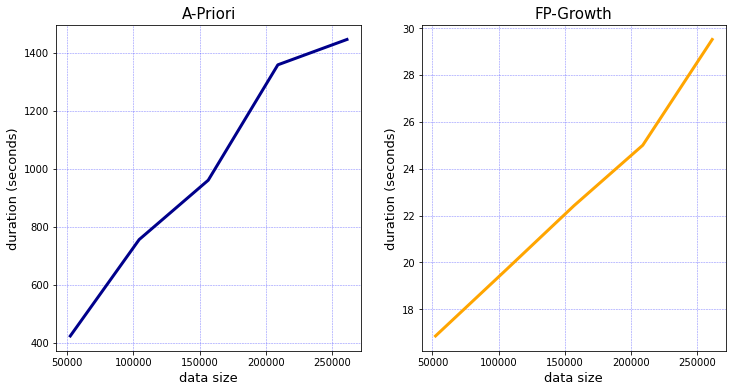

In [54]:
sample_size_apr=[52315,104381,156594,209210,261461]
duration_apr=[451.4128632545471,756.0039114952087,960.7192254066467,1358.4804191589355,1445.8749241828918]

sample_size_fp=[52315,104953,156949,208907,261392]
duration_fp=[16.86421537399292,19.648471117019653,22.420907258987427,24.999815702438354,29.51049566268921]
fig, axes = plt.subplots(1, 2, figsize=(12,6))


axes[0].plot(sample_size_apr, duration_apr,linewidth = 3, color = 'darkblue')
axes[0].grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_title("A-Priori",fontsize = 15)
axes[0].set_xlabel('data size', fontsize = 13)
axes[0].set_ylabel('duration (seconds)', fontsize = 13)

axes[1].plot(sample_size_fp, duration_fp,linewidth = 3, color = 'orange')
axes[1].grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_title("FP-Growth",fontsize = 15)
axes[1].set_xlabel('data size', fontsize = 13)
axes[1].set_ylabel('duration (seconds)', fontsize = 13)


plt.show()